# I - Analyse et features engeneering : 
## - Analyser les df. Voir les features pertinentes. 
## - Faire des merges et réunir la data sur un seul datafram
## - Faire une segmentation RFM : ( Recense - Frequence - Montant) Avec score de 1 à 5 dans chaque. 

In [27]:
# Imports des modules 
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA 
from IPython.display import display 
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

import warnings
warnings.filterwarnings("ignore")

In [37]:
# Import de fonctions de visualisations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, title=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.savefig(title)
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, title=None, cmap=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, cmap=cmap)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [38]:
# Import des différents csv du site kaggle
df_customers = pd.read_csv('./data/olist_customers_dataset.csv')
df_geolocation = pd.read_csv('./data/olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('./data/olist_order_items_dataset.csv')
df_order_paiment = pd.read_csv('./data/olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('./data/olist_orders_dataset.csv')
df_products = pd.read_csv('./data/olist_products_dataset.csv')
df_sellers = pd.read_csv('./data/olist_sellers_dataset.csv')
df_category = pd.read_csv('./data/product_category_name_translation.csv')

- ### On visualise la tailles des différents datafram

In [30]:
# Je print les shape pour avoir une idée de la tailles des données que je possède
print(df_customers.shape)
print(df_geolocation.shape)
print(df_order_items.shape)
print(df_order_paiment.shape)
print(df_order_reviews.shape)
print(df_orders.shape)
print(df_products.shape)
print(df_sellers.shape)
print(df_category.shape)

(99441, 5)
(1000163, 5)
(112650, 7)
(103886, 5)
(99224, 7)
(99441, 8)
(32951, 9)
(3095, 4)
(71, 2)


- ### Je renomme certaines colonnes afin pour simplifier leur utilisation

In [31]:
df_sellers.columns = ['seller_id', 'zipcode', 'geolocation_city', 'geolocation_state']
df_geolocation.columns = ['zipcode', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state']

In [32]:
df_geolocation = df_geolocation.groupby('zipcode').mean().reset_index()
df_geolocation = df_geolocation[['zipcode','geolocation_lat','geolocation_lng']]

- ### On réalise les merges

In [33]:
df1 = df_customers.merge(df_orders, on='customer_id')
df1 = df1.merge(df_order_items, on='order_id')
df1 = df1.merge(df_order_reviews, on='order_id' )
df1 = df1.merge(df_order_paiment, on='order_id')
df1 = df1.merge(df_products, on='product_id')
df1 = df1.merge(df_category, on='product_category_name')
df1 = df1.merge(df_sellers, on='seller_id')
df1 = df1.merge(df_geolocation, on='zipcode')
df1

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,zipcode,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP,-23.486111,-46.366721
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP,-23.486111,-46.366721
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP,-23.486111,-46.366721
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP,-23.486111,-46.366721
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP,-23.486111,-46.366721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115341,ff09fd7b29e7488a8d8a20badcd8befe,8c21dd8c37144807c601f99f2a209dfb,72587,brasilia,DF,157de1652c032429a625d034be79eeeb,delivered,2017-05-10 09:00:07,2017-05-10 09:10:18,2017-05-15 10:06:54,...,200.0,27.0,14.0,13.0,fashion_sport,6038,osasco,SP,-23.565530,-46.778367
115342,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP,2ef4a11b6e24fdfbb43b92cb5f95edff,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,...,500.0,16.0,6.0,16.0,arts_and_craftmanship,17201,jau,SP,-22.294360,-48.558524
115343,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP,2ef4a11b6e24fdfbb43b92cb5f95edff,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,...,500.0,21.0,7.0,14.0,arts_and_craftmanship,17201,jau,SP,-22.294360,-48.558524
115344,ab0cf72dfe0538a63a57d6905ccb7b57,8c3c961a52bb5a0ffbce1d4e6d25cd67,35930,joao monlevade,MG,2c12150c742ae2fa48bc703964c16c5f,delivered,2018-07-28 17:55:27,2018-07-29 18:30:31,2018-07-30 14:54:00,...,1000.0,25.0,25.0,25.0,arts_and_craftmanship,17201,jau,SP,-22.294360,-48.558524


In [22]:
df1.isna().sum()

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1192
order_delivered_customer_date      2397
order_estimated_delivery_date         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
review_id                             0
review_score                          0
review_comment_title             101566
review_comment_message            66540
review_creation_date                  0
review_answer_timestamp               0
payment_sequential                    0


### - Un peu de feature engenering

In [34]:
df2 = df1[['customer_unique_id','product_category_name_english','customer_city','order_purchase_timestamp','order_estimated_delivery_date','order_delivered_customer_date','order_status','review_score','review_answer_timestamp','payment_sequential','payment_type','payment_installments','payment_value','price','freight_value','product_weight_g','geolocation_lat','geolocation_lng','geolocation_city']]


# Environ 10 000 lignes dupliquées sont supprimées
df2 = df2.drop_duplicates()

# Transforme les datetime en une date correspondant à l'année 
df2['order_purchase_timestamp'] = pd.to_datetime(df2['order_purchase_timestamp']).dt.date
df2['order_estimated_delivery_date'] = pd.to_datetime(df2['order_estimated_delivery_date']).dt.date
df2['order_delivered_customer_date'] = pd.to_datetime(df2['order_delivered_customer_date']).dt.date
df2['review_answer_timestamp'] = pd.to_datetime(df2['review_answer_timestamp']).dt.date

# On ajoute une colonne bool si l'achat a été mensualisé
df2['by_credit'] = False 
df2['by_credit'][df2['payment_installments'] > 1] = True 


# On creer des colonnes : Derniere fois que le client à commenter, dérnier achat, temps de livraison estimé, temps réel, si le client à répondu ou non etc.. 
df2['last_review'] = df2['review_answer_timestamp'].max() - df2['review_answer_timestamp']
df2['last_purshase'] = df2['order_purchase_timestamp'].max() - df2['order_purchase_timestamp']
df2['estimed_time'] = df2['order_estimated_delivery_date'] - df2['order_purchase_timestamp']
df2['real_time'] = df2['order_delivered_customer_date'] - df2['order_purchase_timestamp']
df2['real_time'] = np.where(df2['real_time'].isna(), df2['estimed_time'], df2['real_time'])
df2['answer_time'] = df2['order_purchase_timestamp'] - df2['review_answer_timestamp']

df2['answered'] = True
df2['answered'][df2.answer_time <= '-8 days']  = False


# Je retire les commandes qui n'ont pas été livré
df2 = df2[df2['order_status'] == 'delivered']

df2['last_review'] = (df2['last_review'] / np.timedelta64(1, 'D')).astype(int)
df2['last_purshase'] = (df2['last_purshase'] / np.timedelta64(1, 'D')).astype(int)
df2['answer_time'] = (df2['answer_time'] / np.timedelta64(1, 'D')).astype(int)
df2['estimed_time'] = (df2['estimed_time'] / np.timedelta64(1, 'D')).astype(int)
df2['real_time'] =  (df2['real_time'] / np.timedelta64(1, 'D')).astype(int)


df2

,customer_unique_id,product_category_name_english,customer_city,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,review_score,review_answer_timestamp,payment_sequential,...,geolocation_lat,geolocation_lng,geolocation_city,by_credit,last_review,last_purshase,estimed_time,real_time,answer_time,answered
0,861eff4711a542e4b93843c6dd7febb0,office_furniture,franca,2017-05-16,2017-06-05,2017-05-25,delivered,4,2017-05-30,1,...,-23.486111,-46.366721,itaquaquecetuba,True,517,475,20,9,-14,False
1,9eae34bbd3a474ec5d07949ca7de67c0,office_furniture,santarem,2017-11-09,2017-12-19,2017-11-28,delivered,1,2017-12-01,1,...,-23.486111,-46.366721,itaquaquecetuba,False,332,298,40,19,-22,False
3,3c799d181c34d51f6d44bbbc563024db,office_furniture,nova santa rita,2017-05-07,2017-06-12,2017-05-26,delivered,3,2017-05-28,1,...,-23.486111,-46.366721,itaquaquecetuba,True,519,484,36,19,-21,False
4,23397e992b09769faf5e66f9e171a241,office_furniture,mage,2018-02-03,2018-03-22,2018-02-28,delivered,4,2018-03-02,1,...,-23.486111,-46.366721,itaquaquecetuba,True,241,212,47,25,-27,False
5,567ab47ca4deb92d46dbf54dce07d0a7,office_furniture,angelina,2017-03-23,2017-04-24,2017-04-11,delivered,4,2017-04-15,1,...,-23.486111,-46.366721,itaquaquecetuba,True,562,529,32,19,-23,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115341,8c21dd8c37144807c601f99f2a209dfb,fashion_sport,brasilia,2017-05-10,2017-06-01,2017-05-22,delivered,5,2017-05-26,1,...,-23.565530,-46.778367,osasco,True,521,481,22,12,-16,False
115342,8d80e477643ec569b24592ce3d9dfc4c,arts_and_craftmanship,diadema,2018-07-23,2018-08-06,2018-07-27,delivered,3,2018-08-03,1,...,-22.294360,-48.558524,jau,False,87,42,14,4,-11,False
115343,8d80e477643ec569b24592ce3d9dfc4c,arts_and_craftmanship,diadema,2018-07-23,2018-08-06,2018-07-27,delivered,3,2018-08-03,1,...,-22.294360,-48.558524,jau,False,87,42,14,4,-11,False
115344,8c3c961a52bb5a0ffbce1d4e6d25cd67,arts_and_craftmanship,joao monlevade,2018-07-28,2018-08-16,2018-08-03,delivered,5,2018-08-05,1,...,-22.294360,-48.558524,jau,True,85,37,19,6,-8,False


- ### Je regroupe ensuite les commandes par clients unique 

J'ajoute des colonnes : sommes des mensualisations, le nombre d'achat / client , client fidèle ou non, catégory price etc

In [35]:
group_id = df2.groupby('customer_unique_id', observed=True)
group_id_mean = group_id.mean()
group_id_sum = group_id.sum()
group_id_count = group_id.count()

sum_installments = group_id_sum['payment_installments']
sum_paiment = group_id_sum['payment_value']
order_count = group_id_count['product_category_name_english']

group_id_mean = group_id_mean.drop(['freight_value','price'], axis=1)
group_id_mean['sum_installment'] = sum_installments
group_id_mean['sum_paiment'] = sum_paiment
group_id_mean['total_order'] = order_count
group_id_mean = group_id_mean.dropna()

df_model = group_id_mean[['last_purshase','total_order','sum_paiment','review_score','by_credit','last_review','estimed_time','real_time','answer_time','answered','payment_installments','sum_installment','geolocation_lat','geolocation_lng']]
df_model.columns = ['recence', 'frequence','montant','review_score','by_credit','last_review','estimed_time','real_time','answer_time','answered','mean_installment','sum_installment','geolocation_lat','geolocation_lng']

df_model['category_price'] = 0
df_model['category_price'][(df_model['montant'] > 0 ) & (df_model['montant'] < 60 ) ] = 0
df_model['category_price'][(df_model['montant'] >= 60 ) & (df_model['montant'] < 150 ) ] = 1
df_model['category_price'][(df_model['montant'] >= 150 ) & (df_model['montant'] <= df_model['montant'].max() ) ] = 2

df_model['fidelity'] = False
df_model['fidelity'][df_model['frequence'] >= 3] = True 


df_model['delay'] =  df_model['real_time'] - df_model['estimed_time']

# II. Finalement je peux exporter mon df final dans un nouveau csv

In [176]:
df_model2 = df_model[['recence','frequence','montant','review_score','by_credit','last_review','delay','mean_installment']]
df_model2

,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,141.90,5.0,1.0,161.0,-5.0,8.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,27.19,4.0,0.0,171.0,-5.0,1.0
0000f46a3911fa3c0805444483337064,542.0,1,86.22,3.0,1.0,570.0,-2.0,8.0
0000f6ccb0745a6a4b88665a16c9f078,326.0,1,43.62,4.0,1.0,360.0,-12.0,4.0
0004aac84e0df4da2b147fca70cf8255,293.0,1,196.89,5.0,1.0,331.0,-8.0,6.0
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452.0,2,4134.84,5.0,1.0,475.0,-27.0,10.0
fffea47cd6d3cc0a88bd621562a9d061,267.0,1,84.58,4.0,0.0,287.0,-3.0,1.0
ffff371b4d645b6ecea244b27531430a,573.0,1,112.46,5.0,0.0,611.0,-30.0,1.0


In [36]:
# Export du df : 
df_model.to_csv('df_model2.csv')

# Visualisation rapide :

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

kmeans = KMeans(n_clusters = 6)
k_pipe = make_pipeline(StandardScaler(), kmeans)
kmean_pca = make_pipeline( k_pipe, PCA(n_components=0.95))

segmentation_client = k_pipe.fit_transform(df_model)
segmentation_client_pca = kmean_pca.fit_transform(df_model)

df_model['kmean_split'] = kmean_pca[0][1].labels_
df_model['kmean_split'] += 1 


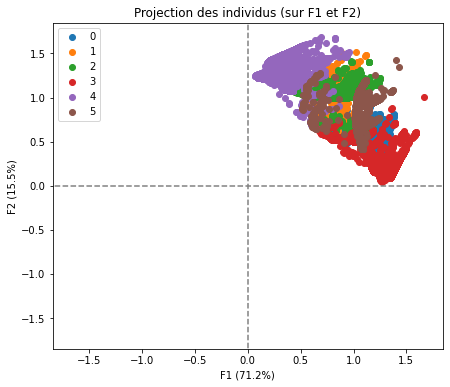

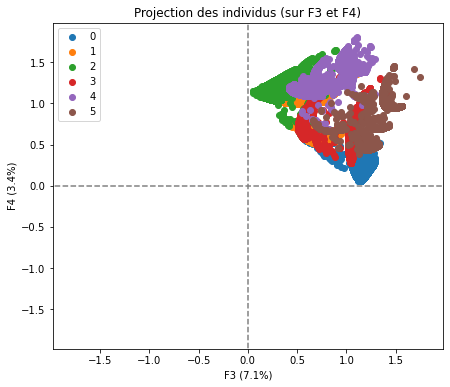

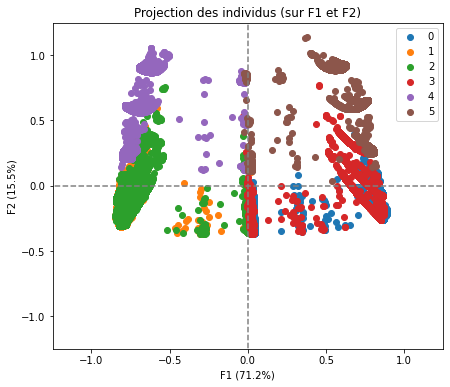

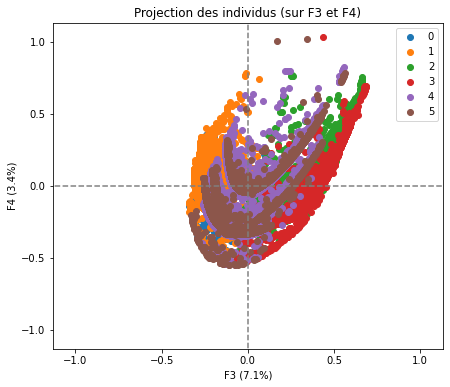

In [137]:
display_factorial_planes(X_projected=segmentation_client, n_comp=5, pca = kmean_pca[1], axis_ranks=[(0,1),(2,3),(4,5)], illustrative_var=df_model2['kmean_split'])
display_factorial_planes(X_projected=segmentation_client_pca, n_comp=5, pca = kmean_pca[1], axis_ranks=[(0,1),(2,3),(4,5)], illustrative_var=df_model2['kmean_split'])